# Ethics, Fairness and Explanation in AI Coursework

Your goal in this coursework is to implement and experiment with various explainability approaches in order to better understand the behaviour of a neural model applied to the Titanic dataset. As you will have a chance to observe, the dataset reflects some of the past social conventions and biases, which also affect the trained model. Explanations can serve as very useful tools for identifying such potential issues and gaining insight into the internal reasoning of machine learning systems.

## Data Loading and Preprocessing

We start by defining some helpful utility functions for data preprocessing. You will probably not need to change this code.

In [64]:
import numpy as np
import pandas as pd
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.utils import resample


class InvertibleColumnTransformer(ColumnTransformer):
    """
    This is an invertible version of a ColumnTransformer from sklearn.
    This allows us to recover the original feature values from their normalised
    versions in order to better understand the produced explanations.
    """
    def inverse_transform(self, X):
        if X.ndim == 1:
            X = np.expand_dims(X, axis=0)
        if X.shape[1] != len(self.get_feature_names_out()):
            raise ValueError(
                "X and the fitted transformer have different numbers of columns"
            )

        inverted_X_base = np.zeros((X.shape[0], self.n_features_in_))
        columns = [c for cs in self._columns for c in cs]
        inverted_X = pd.DataFrame(data=inverted_X_base, columns=columns)
        inverted_X = inverted_X.astype('object')
        for name, indices in self.output_indices_.items():
            transformer = self.named_transformers_.get(name, None)
            if transformer is None:
                continue

            selected_X = X[:, indices.start : indices.stop]
            if isinstance(transformer, OneHotEncoder):
                # Assumed only one column changing encoder at the end
                categories = transformer.inverse_transform(selected_X)
                inverted_X.loc[
                    :, columns[indices.start : indices.start + len(categories[0])]
                ] = categories
            else:
                # Assumed scaler-type transformer
                inverted_X.loc[
                    :, [columns[i] for i in range(indices.start, indices.stop)]
                ] = transformer.inverse_transform(selected_X)

        return inverted_X


def preprocess_train_data(
    df,
    scaled_features=None,
    categorical_features=None,
    scaler=RobustScaler(quantile_range=(10, 90)),
    categorical_encoder=OneHotEncoder(handle_unknown="ignore"),
):
    """
    Scales the continuous features using a RobustScaler and one-hot encodes
    the categorical features.
    """
    if scaled_features is None and categorical_features is None:
        warnings.warn("No features specified for preprocessing, using raw data.")
        scaled_features = []
        categorical_features = []
    elif scaled_features is None:
        scaled_features = [c for c in df.columns if c not in categorical_features]
    elif categorical_features is None:
        categorical_features = [c for c in df.columns if c not in scaled_features]

    preprocessor = InvertibleColumnTransformer(
        transformers=[
            ("num", scaler, scaled_features),
            ("cat", categorical_encoder, categorical_features),
        ],
        remainder="passthrough",
    )

    preprocessed_df = preprocessor.fit_transform(df)
    return preprocessed_df, preprocessor


def preprocess_test_data(df, preprocessor):
    preprocessed_df = preprocessor.transform(df)
    return preprocessed_df

Here, we define a class for the Titanic dataset, which we will be using throughout the coursework.

In [65]:
import os
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


class TitanicDataset(Dataset):
    """
    Loads and preprocesses the Titanic dataset.
    """
    __create_key = object()

    @classmethod
    def create_datasets(
        cls,
        label_name="survived",
        split_seed=42,
        test_size=0.2,
    ):
        train_dataset = TitanicDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=True,
        )
        test_dataset = TitanicDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=False,
        )
        return train_dataset, test_dataset

    def __init__(
        self,
        create_key=None,
        label_name="Survived",
        split_seed=42,
        test_size=0.2,
        train=True,
    ):
        # Ensure that the dataset is being constructed properly
        if create_key != TitanicDataset.__create_key:
            raise ValueError(
                "Illegal initialisation attempt — please use create_datasets to initialise."
            )

        try:
            data_df = pd.read_csv("titanic-dataset.csv")
        except FileNotFoundError:
            raise FileNotFoundError("Titanic data file not found.")

        # Split the dataset into train and test
        x = data_df.drop(columns=[label_name, "name", "ticket", "cabin", "embarked", "boat", "body", "home.dest"])
        # For the purposes of this coursework, we just impute the missing age and fare with a median value
        x[['age']] = x[['age']].fillna(x[['age']].median())
        x[['fare']] = x[['fare']].fillna(x[['fare']].median())
        y = data_df[label_name]
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size, random_state=split_seed, shuffle=True
        )
        if train:
            self.raw_data = x_train, y_train
        else:
            self.raw_data = x_test, y_test

        # Preprocess the data
        x_train_processed, preprocessor = preprocess_train_data(
            x_train, categorical_features=["sex"]
        )
        x_train = pd.DataFrame(
            x_train_processed, columns=preprocessor.get_feature_names_out()
        )
        x_test_processed = preprocess_test_data(x_test, preprocessor)
        x_test = pd.DataFrame(
            x_test_processed, columns=preprocessor.get_feature_names_out()
        )

        # Select data partition and convert to tensors
        if train:
            samples = x_train
            labels = y_train
        else:
            samples = x_test
            labels = y_test
        self.samples = torch.tensor(samples.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(labels.to_numpy(), dtype=torch.long)
        self.features = preprocessor.get_feature_names_out()
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

Finally, we call the code above to load and preprocess the data.

In [66]:
train_dataset, test_dataset = TitanicDataset.create_datasets(
    test_size=0.2,
    split_seed=42,
)
train_dl = DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=False,
)
test_dl = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

Note that the invertible transformer allows you to recover the original (unnormalised) feature values, as shown on the example below. You may find this helpful for understanding the produced explanations and commenting on them in your report.

In [67]:
test_dataset.preprocessor.inverse_transform(test_dataset.samples[:5])

,pclass,age,sibsp,parch,fare,sex
0,3.0,35.0,0.0,0.0,7.125,male
1,3.0,20.0,1.0,1.0,15.7417,male
2,3.0,28.0,0.0,0.0,7.8958,male
3,3.0,28.0,0.0,0.0,8.05,male
4,3.0,28.0,0.0,0.0,7.75,male


## Exploratory Data Analysis

When faced with a new dataset, it is a good practice to perform an exploratory data analysis in order to understand the basic trends in the data. This will also allow you to put the explanations you obtain as part of this coursework into the relevant context. We will use the raw, unnormalised features for this purpose, as they are much more intuitive and human-understandable.

In [68]:
x_train, y_train = train_dataset.raw_data
x_train['survived'] = y_train
data_df = x_train

We start by displaying the feature values and labels for a few samples. The dataset contains data regarding the survival of some of the passengers involved in the [Titanic maritime disaster](https://en.wikipedia.org/wiki/Sinking_of_the_Titanic). The features contained in the data are as follows:
* `pclass`: Indicates the travelling class of the given passenger. Note that we treat this feature as numerical, as the different classes introduce a natural order.
* `sex`: Indicates the sex of the passenger.
* `age`: Provides the age of the passenger.
* `sibsp`: Denotes the total number of siblings and spouses of the given passenger also travelling on RMS Titanic.
* `parch`: Denotes the total number of parents or children of the given passenger also travelling on RMS Titanic.
* `fare`: Indicates the fare paid by the passenger for the journey.
* `survived`: The label indicating whether the patient survived the accident (1 = survived, 0 = did not survive).

There are other features included in the original dataset (such aspassenger name or point of embarkation), but we choose to ignore them for the purposes of this coursework.

In [ ]:
data_df

,pclass,sex,age,sibsp,parch,fare,survived
772,3,male,17.0,0,0,7.8958,0
543,2,male,36.0,0,0,10.5000,0
289,1,female,18.0,0,2,79.6500,1
10,1,male,47.0,1,0,227.5250,0
147,1,male,28.0,0,0,42.4000,0
...,...,...,...,...,...,...,...
1095,3,female,28.0,0,0,7.6292,0
1130,3,female,18.0,0,0,7.7750,0
1294,3,male,28.5,0,0,16.1000,0
860,3,female,26.0,0,0,7.9250,1


Let us visualise the correlation between the individual columns of the data, computed using the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). Note that we excluded the `sex` feature from this visualisation, as it is categorical.

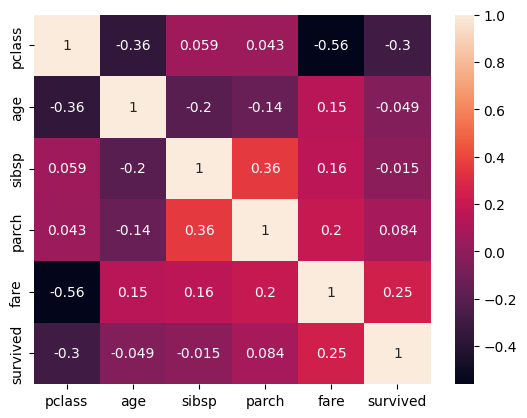

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = data_df.drop(columns=["sex"]).corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    fmt='.2g',
)
plt.show()

Since the previous plot does not include the categorical `sex` column, we also separately visualise its distribution, including the associated labels.

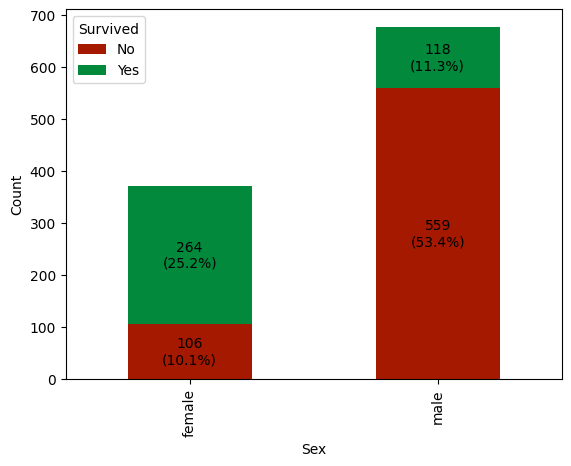

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

grouped = data_df.groupby(['sex', 'survived']).size().unstack()

# Plotting
ax = grouped.plot(kind='bar', stacked=True, color=['#a51900', '#02893b'], xlabel="Sex", ylabel="Count")
plt.legend(['No', 'Yes'], title="Survived")

# Adding annotations
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x + width/2, y + height/2, f'{int(height)}\n({height/grouped.sum().sum()*100:.1f}%)', 
            horizontalalignment='center', verticalalignment='center')

plt.show()

**Task 1(a)**: <br />
**(i)** Considering the above visualisations, are there any trends or patterns that you can identify in the data? <br />
**(ii)** Without having access to any particular model or the associated explanations, which features would you expect to be the most and least important for a neural network trained on the dataset? How can you tell and how certain can you be of your assessment? <br />
**(iii)** Apart from inspecting the above plots, is there anything else you could do as part of the exploratory analysis that would allow you to better understand the data and the behaviour of the models trained on it? <br />
Please write your answers in a few sentences.

## Model Initialisation and Training

First, we define a global device variable to enable running this code on a GPU or a CPU, as needed.

In [72]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(DEVICE)

cpu


Here, we define several utility functions for constructing, training and evaluating neural networks.

In [73]:
import torch
import torch.nn as nn

from torcheval.metrics.functional import binary_f1_score, binary_accuracy, binary_auroc
from tqdm.auto import tqdm

def construct_nn(nn_dims, activation_fun):
    """
    Constructs a neural network with the specified architecture.
    """
    layers = []
    for i in range(1, len(nn_dims)):
        in_dim, out_dim = nn_dims[i-1], nn_dims[i]
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(activation_fun())
    # Remove the last activation layer and add Sigmoid instead
    layers = layers[:-1]
    layers.append(nn.Sigmoid())
    
    return nn.Sequential(*layers).to(DEVICE)

def train_nn(model, train_dl, num_epochs=100):
    """
    Trains a neural network using the data from the provided data loader.
    """
    loss_fun = nn.BCELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=0.005)
    model.train()
    
    losses = []
    for epoch in tqdm(range(num_epochs), leave=False):
        total_loss = 0
        for i, (x, y) in list(enumerate(train_dl)):
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            out = model(x)
            loss = loss_fun(out.squeeze(-1), y.float())
            total_loss += loss.item()
            loss.backward()
            opt.step()
            opt.zero_grad()
        losses.append(total_loss)

def eval_nn(model, test_dataset):
    """
    Evaluates binary classification performance of a model on the given
    test dataset.
    """
    model.eval()

    loss_fun = nn.BCELoss()
    predictions = model(test_dataset.samples.to(DEVICE))
    labels = test_dataset.labels.unsqueeze(-1).to(DEVICE)
    loss = loss_fun(predictions, labels.float()).item()

    predictions = predictions.squeeze(-1).detach()
    labels = labels.squeeze(-1).detach()
    f1 = binary_f1_score(predictions, labels).item()
    accuracy = binary_accuracy(predictions, labels).item()
    auc = binary_auroc(predictions, labels).item()

    return loss, f1, accuracy, auc

In this cell, we initialise and train the neural model that we will be explaining in this coursework. For a real-world application, you would typically wish to perform a full hyperparameter search in order to identify the most effective model architecture. However, achieving a maximum performance is not the objective of this coursework, so we just pre-define a model that performs reasonably well on the given task.

In [74]:
def print_metric(name, value):
    print(f"{name}: {'{:.2f}'.format(round(value, 2))}")

torch.manual_seed(42)
np.random.seed(42)
model = construct_nn([7, 256, 256, 1], nn.ReLU).to(DEVICE)

print("———————[ Model training ]———————")
train_nn(model, train_dl, num_epochs=1000)
print("Training completed!")
print()

print("———————[ Evaluation ]———————")
test_loss, f1, accuracy, auc = eval_nn(model, test_dataset)
print_metric("F1 score", f1)
print_metric("Accuracy", accuracy)
print_metric("AUC", auc)

———————[ Model training ]———————


  0%|          | 0/1000 [00:00<?, ?it/s]

Training completed!

———————[ Evaluation ]———————
F1 score: 0.75
Accuracy: 0.80
AUC: 0.83


## Feature Attributions

In this section of the coursework, you will implement SHAP as introduced in the lectures and conduct additional experiments with various feature attribution methods.

### SHAP Implementation

**Task 2(a)(i)**: As a first step in implementing SHAP, define a `compute_coefficient` function to compute the SHAP coalition coefficient/weight as specified by the formula from the lectures:

$$g_{SHAP}(\mathcal{M},\mathbf{x},i) = \sum_{\mathbf{z} \subseteq \mathbf{x}}{\frac{|\mathbf{z}|!(n - |\mathbf{z}| - 1)! }{n!} \mathcal{M}( \mathbf{z}) - \mathcal{M}(\mathbf{z}_{-i})} \nonumber$$

In [75]:
import math

def compute_coefficient(num_in_coalition, total_features):
    """
    Computes the SHAP coefficient for a coalition.

    Parameters:
        num_in_coalition (int): The number of features in the given coalition
        total_features (int): The total number of considered features

    Returns:
        coefficient (float): The SHAP weight for the given coalition
    """
    # TODO: Your code here

    if total_features == 0:
        return 0.0  # Avoid division by zero

    numerator = math.factorial(num_in_coalition) * math.factorial(total_features - num_in_coalition - 1)
    denominator = math.factorial(total_features)
    
    return numerator / denominator
    

**Task 2(a)(ii)**: Next, define a function `generate_coalitions`, which will return the list representing all the possible coalitions for a possible feature.

Hint #1: You may find it helpful to use [itertools](https://docs.python.org/3/library/itertools.html) and [Python generators](https://wiki.python.org/moin/Generators) for implementing this function.

Hint #2: Passing a full list of feature IDs is not strictly necessary here, but you will find this list helpful for implementing other functions, so we also recommend taking it as a parameter here. As an example, for the Titanic dataset, this list could look like `[0, 1, 2, 3, 4, 5, 5]` (note the repeated `5` for the one-hot-encoded `sex` feature).

In [ ]:
import itertools

def generate_coalitions(feature_ids, target_feature_id):
    """
    Generates the possible feature coalitions for the purpose of computing the Shapley value
    for the target feature.

    Parameters:
        feature_ids (list): A list with feature IDs from 0 to N (where N is
            the total number of features) identifying the used features. Distinct
            columns for one-hot-encoded features should be assigned the same
            numerical ID.
        target_feature_id (int): The ID of the removed feature for which the coalitions
            should be generated.

    Retruns:
        coalitions (list): A nested list structure of coalitions in the form:
            [(set(coalition 1 in features set), set(coalition 1 out features set)), ...].
            Note that feature_id should not appear in either of the in/out lists.
    """
    
    # TODO: Your code here
    coalitions = []
    
    # Exclude the target feature ID from the list of feature_ids
    remaining_features = [feature for feature in feature_ids if feature != target_feature_id]
    
    # Generate all subsets of remaining features
    for subset_size in range(1, len(remaining_features) + 1):
        # Iterate through all combinations of the remaining features
        for coalition_in_features in itertools.combinations(remaining_features, subset_size):
            # Coalition of features included in the subset
            coalition_in_features_set = set(coalition_in_features)
            # Coalition of features excluded from the subset
            coalition_out_features_set = set(feature_ids) - coalition_in_features_set - {target_feature_id}
            coalitions.append((coalition_in_features_set, coalition_out_features_set))
    
    return coalitions    
   

In [77]:
# test the implementation of generate_coalitions

feature_ids = [0, 1, 2, 3, 4, 5, 5]
target_feature_id = 0

coalitions = generate_coalitions(feature_ids, target_feature_id)

print(coalitions)

[({1}, {2, 3, 4, 5}), ({2}, {1, 3, 4, 5}), ({3}, {1, 2, 4, 5}), ({4}, {1, 2, 3, 5}), ({5}, {1, 2, 3, 4}), ({5}, {1, 2, 3, 4}), ({1, 2}, {3, 4, 5}), ({1, 3}, {2, 4, 5}), ({1, 4}, {2, 3, 5}), ({1, 5}, {2, 3, 4}), ({1, 5}, {2, 3, 4}), ({2, 3}, {1, 4, 5}), ({2, 4}, {1, 3, 5}), ({2, 5}, {1, 3, 4}), ({2, 5}, {1, 3, 4}), ({3, 4}, {1, 2, 5}), ({3, 5}, {1, 2, 4}), ({3, 5}, {1, 2, 4}), ({4, 5}, {1, 2, 3}), ({4, 5}, {1, 2, 3}), ({5}, {1, 2, 3, 4}), ({1, 2, 3}, {4, 5}), ({1, 2, 4}, {3, 5}), ({1, 2, 5}, {3, 4}), ({1, 2, 5}, {3, 4}), ({1, 3, 4}, {2, 5}), ({1, 3, 5}, {2, 4}), ({1, 3, 5}, {2, 4}), ({1, 4, 5}, {2, 3}), ({1, 4, 5}, {2, 3}), ({1, 5}, {2, 3, 4}), ({2, 3, 4}, {1, 5}), ({2, 3, 5}, {1, 4}), ({2, 3, 5}, {1, 4}), ({2, 4, 5}, {1, 3}), ({2, 4, 5}, {1, 3}), ({2, 5}, {1, 3, 4}), ({3, 4, 5}, {1, 2}), ({3, 4, 5}, {1, 2}), ({3, 5}, {1, 2, 4}), ({4, 5}, {1, 2, 3}), ({1, 2, 3, 4}, {5}), ({1, 2, 3, 5}, {4}), ({1, 2, 3, 5}, {4}), ({1, 2, 4, 5}, {3}), ({1, 2, 4, 5}, {3}), ({1, 2, 5}, {3, 4}), ({1, 3, 4, 5

**Task 2(a)(iii)**: Next, implement a function `delete_features` that deletes the specified features from the given input tensor `x`. In contrast with the setting in the SHAP tutorial, the majority of features considered in this coursework are non-binary, which makes the deletion of features slightly more challenging. The general procedure for performing the deletion can be described as follows:
1. For each sample in `x` and each deleted feature, randomly sample the value of the deleted feature from another data point in the background dataset
2. If the sampled value is identical to the current value of the deleted feature, continue sampling new values until finding one that differs. This ensures that feature deletion actually changes the values of categorical variables or variables with few possible values.
3. Replace the value of the deleted feature in the currently considered sample with the newly sampled value

Hint #1: Boolean tensor masks "selecting" certain features can be very helpful here.

Hint #2: Make sure not to overwrite values in the original `x` when deleting features. Instead, the function should return a new tensor.

In [78]:
def delete_features(x, background_dataset, feature_ids, deleted_feature_ids):
    """
    Deletes the specified features from inputs x using the background dataset.

    Parameters:
        x (Tensor): A tensor of inputs with the shape (batch_size, num_features).
        background_dataset (Tensor): A tensor of background data samples with the same shape as x.
        feature_ids (list): A list with feature IDs, same as in generate_coalitions.
        deleted_feature_ids (set): A set with feature IDs to be deleted from x.

    Returns:
        x_deleted (tensor): A new tensor of inputs with the specified features deleted.
    """    
    # Make the sampling deterministic
    torch.manual_seed(42)
    np.random.seed(42)

    # TODO: Your code here

    # take a copy so the input x is not overwritten
    x_deleted = x.clone()


    # create a boolean mask for the deleted features
    deleted_feature_indices = [i for i, f_id in enumerate(feature_ids) if f_id in deleted_feature_ids]
    mask = torch.zeros(x.size(1), dtype=torch.bool)  
    
    mask[deleted_feature_indices] = True  # set True for deleted features
    
    # iterate over each sample in x
    for i in range(x.size(0)):

        while True:

            # randomly select from the background dataset
            sample_index = np.random.randint(0, background_dataset.size(0))
            
            sampled_values = background_dataset[sample_index, mask]
            
            # ensure the sampled values are different from the current values
            if not torch.any(sampled_values == x_deleted[i, mask]):
                break

        # replace the values of the deleted features with the sampled values
        x_deleted[i, ~mask] = x[i, ~mask]
        x_deleted[i, mask] = sampled_values

    return x_deleted

In [ ]:
# test the implementation of delete_features

random_indices = np.random.choice(len(test_dataset), 5, replace = False)
selected_rows = test_dataset.samples[random_indices]

selected_rows
x_deleted = delete_features(selected_rows,  test_dataset.samples, [0,1,2,3,4,5,5], [1,5])
x_deleted == selected_rows # This returns `False` if features were successfully deleted


tensor([[ True, False,  True,  True,  True, False, False],
        [ True, False,  True,  True,  True, False, False],
        [ True, False,  True,  True,  True, False, False],
        [ True, False,  True,  True,  True, False, False],
        [ True, False,  True,  True,  True, False, False]])

**Task 2(a)(iv)**: Finally, put everything together in the `shap_attribute` function, which will compute the SHAP attributions for the given input and model. Note that the function also takes in a `target_idx` specifying for which output neuron the explanations should be computed. This is not strictly necessary for the Titanic model, which only has a single Sigmoid output, but will be needed once you start working with a more complex model.

In [ ]:
def shap_attribute(model, x, background_dataset, feature_ids, target_idx=0):
    """
    Computes the SHAP attributions for the given input and model.

    Parameters:
        model (Object): A PyTorch model for which the attributions should be computed.
        x (Tensor): Inputs for which the explanations should be computed, in shape (batch_size, num_features).
        background_dataset (Tensor): A tensor of background data samples with the same shape as x.
        feature_ids (list): A list with feature IDs, same as in generate_coalitions.
        target_idx (int): The ID of the target neuron for which to compute an explanation.

    Returns:
        attributions (Tensor): A tensor of SHAP attributions, with the same shape as the input.
    """
    # Initialize the attributions tensor
    batch_size, num_features = x.shape
    attributions = torch.zeros_like(x)

    # Iterate over each feature to compute its SHAP value
    for i, target_feature_id in enumerate(feature_ids):  # Use set to handle duplicates
        # Generate all coalitions for the target feature
        coalitions = generate_coalitions(feature_ids, target_feature_id)

        shap_value=0
        # Iterate over each coalition
        for coalition_in, coalition_out in coalitions:
            # Compute the SHAP coefficient for this coalition
            num_in_coalition = len(coalition_in)
            total_features = len(feature_ids)  # Use set to handle duplicates
            coefficient = compute_coefficient(num_in_coalition, total_features)

            # Delete features in the coalition_out set
            x_deleted = delete_features(x, background_dataset, feature_ids, coalition_out)

            # Compute the model's output with the coalition_in features
            with torch.no_grad():
                output_in = model(x_deleted)[:, target_idx]

            # Delete features in the coalition_in set (including the target feature)
            x_deleted_target = delete_features(x, background_dataset, feature_ids, coalition_in | {target_feature_id})

            # Compute the model's output without the coalition_in features
            with torch.no_grad():
                output_out = model(x_deleted_target)[:, target_idx]

            # Compute the marginal contribution of the target feature
            marginal_contribution = output_in - output_out
            shap_value+=coefficient*marginal_contribution
            
        attributions[:, i] = shap_value
    return attributions

### Additional Explanation Methods

Apart from SHAP, which you just implemented, you will also be experimenting with two more feature attribution methods implemented in the [Captum](https://captum.ai/) library — [Shapley Value Sampling](https://captum.ai/api/shapley_value_sampling.html) and [DeepLIFT](https://captum.ai/api/deep_lift.html). Shapley Value Sampling is a more computationally tractable approximation of SHAP and computes the scores by randomly sampling a fixed number of coalitions instead of considering all of them. Meanwhile, DeepLIFT is a fast gradient-based attribution method specifically designed for neural models. If you are interested, you can learn more about DeepLIFT in [its original paper](https://arxiv.org/abs/1704.02685).

To get you started, we provide an example of how to use the Captum library to generate Shapley Value Sampling attributions for the first sample from the Titanic test set (note that the library also allows you to compute attributions for a batch of inputs):

In [82]:
from captum.attr import ShapleyValueSampling

# Note that this is similar to feature_ids from the implementation above,
# but the shape and the data type are different
feature_mask = torch.tensor([[0, 1, 2, 3, 4, 5, 5]]).to(DEVICE)
svs = ShapleyValueSampling(model)
attributions = svs.attribute(test_dataset.samples[[0]].to(DEVICE), target=0, feature_mask=feature_mask)
attributions

tensor([[ 0.0000,  0.1988,  0.0000,  0.0000,  0.1638, -0.5639, -0.5639]])

Notice that, in contrast with the SHAP implementation above, we did not need to pass in the background dataset. This is because Captum takes a slightly different approach to deleting features and instead replaces them with a pre-specified baseline value (see the `baselines` parameter description in the [documentation](https://captum.ai/api/shapley_value_sampling.html)). For the purposes of this coursework, it is fine to use the default (zero) baseline for both Shapley Value Sampling and DeepLIFT.

### Feature Attribution Experiments

In this section, you will conduct several experiments associated with feature attribution methods.

**Task 2(b)**: Using your implementation of SHAP and Captum implementations of Shapley Value Sampling and DeepLIFT, compute feature attributions for 10 randomly selected instances from the Titanic test set. Then answer the following questions: <br />
**(i)** Which features generally seem to be the most important and least important for the explained model according to each of the explanations? <br />
**(ii)** Are there any substantial differences between the different attribution methods? What might be the possible reasons for the different methods returning different attribution scores? <br />
**(iii)** Do the attribution scores match your expectations for the most/least important features from task 1(a)(ii)? What might be the reasons for a user's expected explanations differing from the computed attribution explanations? <br />
**(iv)** Considering the insights gained from the exploratory data analysis and the feature attribution explanations, as well as the definitions of the explanations themselves, what are the potential advantages/disadvantages of each of these methods when trying to understand the behaviour of a model on a particular dataset? <br />

In [83]:
# TODO: Your code and experiments here
import torch
from captum.attr import ShapleyValueSampling, DeepLift
import numpy as np
import random
random.seed(42)

# Randomly select 10 instances from the Titanic test set
random_indices = random.sample(range(len(test_dataset.samples)), 10)
selected_samples = [test_dataset.samples[idx] for idx in random_indices]

print(selected_samples)
# Convert the selected samples to tensor and move them to the same device as the model
input_tensor = torch.stack(selected_samples)
print("input_tensor", input_tensor)

# Analyze results
def analyze_attributions(attributions, feature_names):
    avg_attributions = torch.mean(torch.abs(attributions), dim=0) # torch.abs(attributions)
    ranked_features = sorted(zip(feature_names, avg_attributions), key=lambda x: x[1], reverse=True)
    print("Ranked Features:")
    for feature, score in ranked_features:
        print(f"{feature}: {score:.4f}")
    return ranked_features

[tensor([-1.0000,  0.2581,  0.0000,  0.5000,  7.0881,  0.0000,  1.0000]), tensor([ 0.0000, -0.4516,  1.0000,  0.0000, -0.0464,  1.0000,  0.0000]), tensor([ 0.0000,  0.0000,  0.0000,  0.0000, -0.0940,  0.0000,  1.0000]), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5979, 0.0000, 1.0000]), tensor([-1.0000,  0.3548,  1.0000,  0.5000,  0.9276,  1.0000,  0.0000]), tensor([-0.5000, -0.3226,  0.0000,  0.0000, -0.0427,  0.0000,  1.0000]), tensor([-1.0000,  0.7742,  0.0000,  0.0000,  0.2278,  0.0000,  1.0000]), tensor([ 0.0000, -0.3871,  0.0000,  0.0000, -0.0752,  0.0000,  1.0000]), tensor([-0.5000, -0.8065,  1.0000,  1.0000,  0.3856,  1.0000,  0.0000]), tensor([ 0.0000,  0.0000,  0.0000,  0.0000, -0.1035,  0.0000,  1.0000])]
input_tensor tensor([[-1.0000,  0.2581,  0.0000,  0.5000,  7.0881,  0.0000,  1.0000],
        [ 0.0000, -0.4516,  1.0000,  0.0000, -0.0464,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000, -0.0940,  0.0000,  1.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,

In [ ]:
# ------------------------- SHAP Implementation -------------------------

# Create the background dataset for SHAP, which should have the same shape as the input tensor.
# This dataset is typically a subset of the training data used to approximate the expected model output.

# Construct the background dataset by excluding the randomly selected test samples from the training dataset.
background_samples = [train_dataset.samples[idx] for idx in range(len(train_dataset.samples)) if idx not in random_indices]

# Convert the list of background samples into a PyTorch tensor
background_dataset = torch.stack(background_samples)

# Print the size of the background dataset for verification
print(background_dataset.size())

# Define the feature indices to be used for SHAP attribution analysis.
feature_ids = [0, 1, 2, 3, 4, 5, 5]

# Compute SHAP attributions for the given model, input tensor, and background dataset.
attributions_shap = shap_attribute(model, input_tensor, background_dataset, feature_ids)

# Print the raw SHAP attributions to inspect the results
print(attributions_shap)

# Compute and print the mean SHAP attribution across all instances to understand feature importance
print(attributions_shap.mean(dim=0))

# Define human-readable feature names corresponding to the feature indices
feature_names = ["pclass", "age", "sibsp", "parch", "fare", "sex_m", "sex_f"]

# Analyze and visualize the SHAP attributions for better interpretability
analyze_attributions(attributions_shap, feature_names)


torch.Size([1037, 7])
tensor([[ 0.0889, -0.0807, -0.1040, -0.0344,  0.2962, -0.0973, -0.0973],
        [ 0.0720,  0.3856,  0.1973,  0.1664,  0.1779,  0.2275,  0.2275],
        [-0.2526, -0.1897, -0.0750, -0.2945, -0.3079, -0.1499, -0.1499],
        [-0.2670, -0.0073, -0.1186, -0.0041, -0.1063, -0.1621, -0.1621],
        [ 0.4144,  0.2094,  0.1698,  0.1449,  0.2294,  0.2550,  0.2550],
        [-0.1043, -0.1918,  0.0211, -0.1389, -0.1788, -0.1536, -0.1536],
        [ 0.0990, -0.1773,  0.0432, -0.1496, -0.0296, -0.1461, -0.1461],
        [-0.3305, -0.0990, -0.1506, -0.1860, -0.2190, -0.2161, -0.2161],
        [ 0.2240,  0.2132,  0.1295,  0.1019,  0.1197,  0.1264,  0.1264],
        [-0.2409, -0.1485, -0.1490, -0.1823, -0.2135, -0.1798, -0.1798]])
tensor([-0.0297, -0.0086, -0.0036, -0.0577, -0.0232, -0.0496, -0.0496])
Ranked Features:
pclass: 0.2094
fare: 0.1878
sex_m: 0.1714
sex_f: 0.1714
age: 0.1702
parch: 0.1403
sibsp: 0.1158


[('pclass', tensor(0.2094)),
 ('fare', tensor(0.1878)),
 ('sex_m', tensor(0.1714)),
 ('sex_f', tensor(0.1714)),
 ('age', tensor(0.1702)),
 ('parch', tensor(0.1403)),
 ('sibsp', tensor(0.1158))]

In [ ]:
# TODO: Your code and experiments here

# ------------------ Shapley Value Sampling using Captum -------------------

svs = ShapleyValueSampling(model)

# Create a feature mask (same as feature_ids)
feature_mask = torch.tensor([[0, 1, 2, 3, 4, 5, 5]]) 

# Define the baseline data (reference input) as a tensor of zeros with the same shape as the input tensor.
baseline_data = torch.zeros_like(input_tensor)


# Compute Shapley Value Sampling attributions for the input tensor.
svs_attribution = svs.attribute(input_tensor, target=0, feature_mask=feature_mask, baselines=baseline_data)

# Print the computed attributions to inspect individual feature contributions
print(svs_attribution)

# Compute and print the mean attributions across all samples to understand overall feature importance
print("Mean attribution:", svs_attribution.mean(dim=0))

# Analyze and visualize the attributions using the feature names
analyze_attributions(svs_attribution, feature_names)

tensor([[ 0.0251,  0.1321,  0.0000,  0.1669,  0.7283, -0.2619, -0.2619],
        [ 0.0000,  0.3414,  0.4085,  0.0000,  0.2466, -0.2102, -0.2102],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.2567, -0.3737, -0.3737],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.5078,  0.0834,  0.0834],
        [ 0.5806,  0.0310,  0.1433, -0.0906,  0.1477, -0.0215, -0.0215],
        [ 0.3112, -0.0902,  0.0000,  0.0000,  0.0337, -0.4619, -0.4619],
        [ 0.4926,  0.3191,  0.0000,  0.0000,  0.3193, -0.3854, -0.3854],
        [ 0.0000, -0.0675,  0.0000,  0.0000,  0.2931, -0.2580, -0.2580],
        [ 0.4379,  0.2193,  0.1215,  0.0077,  0.0012,  0.0030,  0.0030],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.2583, -0.4033, -0.4033]])
mean tensor([ 0.1847,  0.0885,  0.0673,  0.0084,  0.2793, -0.2289, -0.2289])
Ranked Features:
fare: 0.2793
sex_m: 0.2462
sex_f: 0.2462
pclass: 0.1847
age: 0.1201
sibsp: 0.0673
parch: 0.0265


[('fare', tensor(0.2793)),
 ('sex_m', tensor(0.2462)),
 ('sex_f', tensor(0.2462)),
 ('pclass', tensor(0.1847)),
 ('age', tensor(0.1201)),
 ('sibsp', tensor(0.0673)),
 ('parch', tensor(0.0265))]

In [ ]:
# ------------------ DeepLIFT Attribution using Captum -------------------

# Initialize the DeepLIFT attribution method from Captum
# DeepLIFT helps identify how much each input feature contributes to the model’s prediction
deep_lift = DeepLift(model)

# Define the baseline data (reference input) as a tensor of zeros with the same shape as the input tensor.
baseline_data = torch.zeros_like(input_tensor)

# Compute DeepLIFT attributions for the input tensor.
deeplift_attribution = deep_lift.attribute(input_tensor, target=0, baselines=baseline_data)

# Print the mean attributions across all samples to understand overall feature importance
print(deeplift_attribution.mean(dim=0))

# Analyze and visualize the DeepLIFT attributions using the feature names
analyze_attributions(deeplift_attribution, feature_names)


tensor([ 0.2030,  0.0697,  0.0747,  0.0224,  0.3090, -0.0155, -0.2640],
       grad_fn=<MeanBackward1>)
Ranked Features:
fare: 0.3790
sex_f: 0.2640
pclass: 0.2388
age: 0.1196
sibsp: 0.0747
sex_m: 0.0548
parch: 0.0404


c:\Users\SUNITA\anaconda3\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\Users\SUNITA\anaconda3\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


[('fare', tensor(0.3790, grad_fn=<UnbindBackward0>)),
 ('sex_f', tensor(0.2640, grad_fn=<UnbindBackward0>)),
 ('pclass', tensor(0.2388, grad_fn=<UnbindBackward0>)),
 ('age', tensor(0.1196, grad_fn=<UnbindBackward0>)),
 ('sibsp', tensor(0.0747, grad_fn=<UnbindBackward0>)),
 ('sex_m', tensor(0.0548, grad_fn=<UnbindBackward0>)),
 ('parch', tensor(0.0404, grad_fn=<UnbindBackward0>))]

**Task 2(c)**: Perform a quantitative evaluation of the different attribution methods by computing their mean [infidelity](https://captum.ai/api/metrics.html) on the full Titanic dataset. On a high level, infidelity aims to estimate how closely the generated explanations correspond with the behaviour of the explained model by slightly perturbing the inputs and measuring how much the observed change in the model output differs from the change predicted by the corresponding feature attributions (when considering a linear model with the same weights as the feature attribution scores). If you are interested, you can find more details regarding this metric in [the original paper](https://arxiv.org/abs/1901.09392). A downside of the infidelity metric is that one needs to define a suitable perturbation function for changing the model inputs, which can significantly affect the results. In this coursework, we provide you with a perturbation function adding Gaussian noise to continuous features and performing resampling for categorical features. In your evaluation, you should experiment with two or three different standard deviations and categorical resampling probabilities. Once you are done, add a table summarising the results to your report and comment on the findings. Note that lower infidelity scores are better.

Note: You should use `normalize=True` and `n_perturb_samples=10` as parameters to the Captum's infidelity function and set the same Torch and NumPy seeds before computing the infidelity for each method (so that all methods are evaluated using the same sample perturbations).

In [87]:
from captum.metrics import infidelity, infidelity_perturb_func_decorator

def perturb_func_constructor(noise_scale, cat_resample_proba, background_dataset, feature_ids, n_perturb_samples=10):
    """
    You can call this function to construct a perturbation function with the desired parameters,
    which can then be provided as the perturb_func parameter to the infidelity metric implementation
    from Captum.

     Parameters:
        noise_scale (float): A standard deviation of the Gaussian noise added to the continuous features.
        cat_resample_proba (float): Probability of resampling a categorical feature.
        background_dataset (Tensor): A tensor of background data samples with the shape (num_samples, num_features).
        feature_ids (list): A list with feature IDs, same as in generate_coalitions.
        n_perturb_samples (int): The number of perturbed samples for each input. Should match the value
            of the corresponding parameter to the Captum's infidelity function.

    Returns:
        perturb_func (function): A perturbation function compatible with Captum
    """
    @infidelity_perturb_func_decorator(True)
    def perturb_func(inputs):        
        # Construct masks for noise and resampling categorical variables
        noise_mask = torch.ones(1, inputs.size(1)).to(DEVICE)
        # We assume that categorical features are one-hot-encoded
        i = 0
        current_span_start = 0
        categorical_spans = []
        while i < len(feature_ids) - 1:    
            if feature_ids[i] != feature_ids[i + 1] and current_span_start != i:
                categorical_spans.append((current_span_start, i))
                current_span_start = i + 1
            elif feature_ids[i] != feature_ids[i + 1]:
                current_span_start = i + 1
            elif feature_ids[i] == feature_ids[i + 1] and i == len(feature_ids) - 2:
                categorical_spans.append((current_span_start, i + 1))
            i += 1
                
        cat_resample_masks = []
        for i, (s, e) in enumerate(categorical_spans):
            cat_resample_mask = torch.zeros(inputs.shape).to(DEVICE)
            probabilities = torch.full((inputs.size(0), 1), cat_resample_proba)
            resample_tensor = torch.bernoulli(probabilities)
            noise_mask[:, s:e] = 0.
            cat_resample_mask[:, s:e] = resample_tensor
            cat_resample_masks.append(cat_resample_mask)

        # Add noise to continuous features only
        noise = torch.tensor(np.random.normal(0, noise_scale, inputs.shape)).float().to(DEVICE) * noise_mask
        perturbed_inputs = inputs - noise

        # Randomly resample categorical variables
        if categorical_spans:
            expanded_background_dataset = background_dataset.repeat((n_perturb_samples, 1))
            for cat_resample_mask in cat_resample_masks:
                random_perm = torch.randperm(expanded_background_dataset.size(0))
                random_samples = expanded_background_dataset[random_perm[:inputs.size(0)]]
                perturbed_inputs = perturbed_inputs * (1 - cat_resample_mask) + random_samples * cat_resample_mask

        return perturbed_inputs

    return perturb_func

In [ ]:
# Print the number of samples in the training dataset
print("Number of training samples:", len(train_dataset.samples))

# Print the number of samples in the test dataset
print("Number of test samples:", len(test_dataset.samples))

# Concatenate the training and test datasets to create a single unified dataset
whole_dataset = torch.cat([train_dataset.samples, test_dataset.samples], dim=0)

# Verify the shape of the concatenated dataset
print("Shape of the combined dataset:", whole_dataset.shape)

# Print the full dataset (use cautiously if the dataset is large)
print("Combined dataset:\n", whole_dataset)

# Define the feature indices to be used for analysis or attributions
feature_ids = [0, 1, 2, 3, 4, 5, 5]


1047
262
torch.Size([1309, 7])
tensor([[ 0.0000, -0.3548,  0.0000,  ..., -0.0940,  0.0000,  1.0000],
        [-0.5000,  0.2581,  0.0000,  ..., -0.0570,  0.0000,  1.0000],
        [-1.0000, -0.3226,  0.0000,  ...,  0.9276,  1.0000,  0.0000],
        ...,
        [ 0.0000, -0.2258,  0.0000,  ..., -0.0975,  1.0000,  0.0000],
        [-1.0000,  0.7097,  1.0000,  ...,  2.8049,  0.0000,  1.0000],
        [-1.0000, -0.1290,  0.0000,  ...,  0.4984,  1.0000,  0.0000]])


In [ ]:
# The shap_attribute function to compute SHAP values for feature importance analysis
attributions_shap = shap_attribute(model, whole_dataset, whole_dataset, feature_ids)

In [ ]:
# Create baseline data for SHAP or DeepLIFT attribution, initialized as zeros 
baseline_data = torch.zeros_like(whole_dataset)

# Calculate SHAP values using the SVS method (SHAP Values with SHAP-Vanishing Strategy)
svs_attribution = svs.attribute(whole_dataset, target=0, feature_mask=feature_mask, baselines=baseline_data)

# Calculate SHAP values using the DeepLIFT method
deeplift_attribution = deep_lift.attribute(whole_dataset, target=0, baselines=baseline_data)


In [91]:
# TODO: Your code and experiments here
from captum.metrics import infidelity
import torch
import numpy as np

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Define hyperparameters
noise_scales = [0.1, 0.5, 0.9]
cat_resample_probas = [0.1, 0.5, 0.9]

# Initialize results table
results = []

x = whole_dataset # input_tensor

# Iterate over hyperparameters
for noise_scale in noise_scales:
    for cat_resample_proba in cat_resample_probas:
        # Construct perturbation function
        perturb_func = perturb_func_constructor(
            noise_scale=noise_scale,
            cat_resample_proba=cat_resample_proba,
            background_dataset=whole_dataset,
            feature_ids=feature_ids,
            n_perturb_samples=10
        )

        # Compute infidelity for each attribution method
        infidelity_shap = infidelity(
            model,
            perturb_func,
            x,
            attributions=attributions_shap,
            normalize=True,
            n_perturb_samples=10
        ).mean().item()

        infidelity_shapley_sampling = infidelity(
            model,
            perturb_func,
            x,
            attributions=svs_attribution,
            normalize=True,
            n_perturb_samples=10
        ).mean().item()

        infidelity_deeplift = infidelity(
            model,
            perturb_func,
            x,
            attributions=deeplift_attribution,
            normalize=True,
            n_perturb_samples=10
        ).mean().item()

        # Store results
        results.append({
            "Noise Scale": noise_scale,
            "Categorical Resampling Probability": cat_resample_proba,
            "SHAP Infidelity": infidelity_shap,
            "Shapley Value Sampling Infidelity": infidelity_shapley_sampling,
            "DeepLIFT Infidelity": infidelity_deeplift
        })

# Print results table
print("Infidelity Results:")
for result in results:
    print(f"Noise Scale: {result['Noise Scale']}, "
          f"Categorical Resampling Probability: {result['Categorical Resampling Probability']}, "
          f"SHAP Infidelity: {result['SHAP Infidelity']:.4f}, "
          f"Shapley Value Sampling Infidelity: {result['Shapley Value Sampling Infidelity']:.4f}, "
          f"DeepLIFT Infidelity: {result['DeepLIFT Infidelity']:.4f}")

Infidelity Results:
Noise Scale: 0.1, Categorical Resampling Probability: 0.1, SHAP Infidelity: 0.0898, Shapley Value Sampling Infidelity: 0.0897, DeepLIFT Infidelity: 0.0874
Noise Scale: 0.1, Categorical Resampling Probability: 0.5, SHAP Infidelity: 0.0935, Shapley Value Sampling Infidelity: 0.0907, DeepLIFT Infidelity: 0.0930
Noise Scale: 0.1, Categorical Resampling Probability: 0.9, SHAP Infidelity: 0.0958, Shapley Value Sampling Infidelity: 0.0902, DeepLIFT Infidelity: 0.0990
Noise Scale: 0.5, Categorical Resampling Probability: 0.1, SHAP Infidelity: 0.2124, Shapley Value Sampling Infidelity: 0.1993, DeepLIFT Infidelity: 0.2026
Noise Scale: 0.5, Categorical Resampling Probability: 0.5, SHAP Infidelity: 0.2178, Shapley Value Sampling Infidelity: 0.2080, DeepLIFT Infidelity: 0.2101
Noise Scale: 0.5, Categorical Resampling Probability: 0.9, SHAP Infidelity: 0.2246, Shapley Value Sampling Infidelity: 0.2215, DeepLIFT Infidelity: 0.2183
Noise Scale: 0.9, Categorical Resampling Probabili

**Task 2(d)**: Evaluate the computational efficiency of the different methods by taking the following steps: <br />
**(i)** Preproccess the [Dry Bean Dataset](https://archive.ics.uci.edu/dataset/602/dry+bean+dataset), similarly to what we have done for Titanic. You can find the description of the different features on the dataset webpage along with the instructions on how to import the data in a Python environment. You do not need to perform any exploratory data analysis for this dataset. <br />
**(ii)** Train an additional neural model on the preprocessed data. Briefly report the key performance metrics for the model in your report. <br />
**(iii)** Compute the runtimes required to produce the attribution scores for the different methods when considering the first 200 samples in the Titanic and Dry Bean test sets. Report the results in a table in your report. Which methods seem to be the most/least computationally efficient?

In [92]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
dry_bean = fetch_ucirepo(id=602) 
  
# data (as pandas dataframes) 
X = dry_bean.data.features 
y = dry_bean.data.targets 


In [93]:
import numpy as np
import pandas as pd
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
from ucimlrepo import fetch_ucirepo

# Fetch the Dry Bean Dataset
dry_bean = fetch_ucirepo(id=602)
X = dry_bean.data.features
y = dry_bean.data.targets

X = X.iloc[:, :11]
# Convert target labels to numerical values (if necessary)
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Define the DryBeanDataset class
class DryBeanDataset(Dataset):
    __create_key = object()

    @classmethod
    def create_datasets(
        cls,
        label_name="Class",
        split_seed=42,
        test_size=0.2,
    ):
        train_dataset_beans = DryBeanDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=True,
        )
        test_dataset_beans = DryBeanDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=False,
        )
        return train_dataset_beans, test_dataset_beans

    def __init__(
        self,
        create_key=None,
        label_name="Class",
        split_seed=42,
        test_size=0.2,
        train=True,
    ):
        if create_key != DryBeanDataset.__create_key:
            raise ValueError(
                "Illegal initialisation attempt — please use create_datasets to initialise."
            )

        # Split the dataset into train and test
        x_train, x_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=split_seed, shuffle=True
        )
        if train:
            self.raw_data = x_train, y_train
        else:
            self.raw_data = x_test, y_test

        # Preprocess the data
        x_train_processed, preprocessor = preprocess_train_data(
            x_train, scaled_features=X.columns.tolist()
        )
        x_train = pd.DataFrame(
            x_train_processed, columns=preprocessor.get_feature_names_out()
        )
        x_test_processed = preprocess_test_data(x_test, preprocessor)
        x_test = pd.DataFrame(
            x_test_processed, columns=preprocessor.get_feature_names_out()
        )

        # Select data partition and convert to tensors
        if train:
            samples = x_train
            labels = y_train
        else:
            samples = x_test
            labels = y_test
        self.samples = torch.tensor(samples.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.features = preprocessor.get_feature_names_out()
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

# Preprocessing functions
def preprocess_train_data(
    df,
    scaled_features=None,
    categorical_features=None,
    scaler=RobustScaler(quantile_range=(10, 90)),
):
    if scaled_features is None and categorical_features is None:
        warnings.warn("No features specified for preprocessing, using raw data.")
        scaled_features = []
        categorical_features = []
    elif scaled_features is None:
        scaled_features = [c for c in df.columns if c not in categorical_features]
    elif categorical_features is None:
        categorical_features = [c for c in df.columns if c not in scaled_features]

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", scaler, scaled_features),
        ],
        remainder="passthrough",
    )

    preprocessed_df = preprocessor.fit_transform(df)
    return preprocessed_df, preprocessor

def preprocess_test_data(df, preprocessor):
    preprocessed_df = preprocessor.transform(df)
    return preprocessed_df

# Create datasets and dataloaders
train_dataset_beans, test_dataset_beans = DryBeanDataset.create_datasets(
    test_size=0.2,
    split_seed=42,
)
train_dl_beans = DataLoader(
    dataset=train_dataset_beans,
    batch_size=128,
    shuffle=False,
)
test_dl_beans = DataLoader(
    dataset=test_dataset_beans,
    batch_size=64,
    shuffle=False,
)

# Print dataset details
print("Training dataset size:", len(train_dataset_beans))
print("Testing dataset size:", len(test_dataset_beans))
print("Features:", train_dataset_beans.features)

Training dataset size: 10888
Testing dataset size: 2723
Features: ['num__Area' 'num__Perimeter' 'num__MajorAxisLength'
 'num__MinorAxisLength' 'num__AspectRatio' 'num__Eccentricity'
 'num__ConvexArea' 'num__EquivDiameter' 'num__Extent' 'num__Solidity'
 'num__Roundness']


c:\Users\SUNITA\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
train_dataset.samples # To observe the number of samples in train_dataset

tensor([[ 0.0000, -0.3548,  0.0000,  ..., -0.0940,  0.0000,  1.0000],
        [-0.5000,  0.2581,  0.0000,  ..., -0.0570,  0.0000,  1.0000],
        [-1.0000, -0.3226,  0.0000,  ...,  0.9276,  1.0000,  0.0000],
        ...,
        [ 0.0000,  0.0161,  0.0000,  ...,  0.0228,  0.0000,  1.0000],
        [ 0.0000, -0.0645,  0.0000,  ..., -0.0936,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ..., -0.0940,  1.0000,  0.0000]])

In [95]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Define the Neural Network Model
class DryBeanClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(DryBeanClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Hyperparameters
input_size = len(train_dataset_beans.features)  # Number of features
hidden_size = 64  # Number of neurons in the hidden layer
num_classes = 7  # Number of classes in the Dry Bean Dataset
learning_rate = 0.001
num_epochs = 20
batch_size = 128

# Initialize the model, loss function, and optimizer
model_bean = DryBeanClassifier(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_bean.parameters(), lr=learning_rate)

# Training Loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    for i, (inputs, labels) in enumerate(train_dl_beans):
        # Forward pass
        outputs = model_bean(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Print loss for every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# Evaluation
model_bean.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []
all_probs = []
total_loss = 0
num_batches = 0

with torch.no_grad():
    for inputs, labels in test_dl_beans:
        outputs = model_bean(inputs)
        loss = criterion(outputs, labels)
        total_loss += loss.item()
        num_batches += 1
        _, preds = torch.max(outputs, 1)  # Get the predicted class
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())

# Calculate metrics
avg_loss = total_loss / num_batches
accuracy = accuracy_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average="weighted")

# Compute AUC (only if num_classes > 2)
if num_classes > 2:
    auc = roc_auc_score(all_labels, all_probs, multi_class="ovr")
else:
    auc = roc_auc_score(all_labels, [p[1] for p in all_probs])  # Binary case

# Print results
print(f"Test Loss: {avg_loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Test F1 Score: {f1:.4f}")
print(f"Test AUC Score: {auc:.4f}")

Epoch [1/20], Loss: 1.0659
Epoch [2/20], Loss: 0.4969
Epoch [3/20], Loss: 0.2944
Epoch [4/20], Loss: 0.2082
Epoch [5/20], Loss: 0.1716
Epoch [6/20], Loss: 0.1532
Epoch [7/20], Loss: 0.1428
Epoch [8/20], Loss: 0.1363
Epoch [9/20], Loss: 0.1320
Epoch [10/20], Loss: 0.1288
Epoch [11/20], Loss: 0.1264
Epoch [12/20], Loss: 0.1246
Epoch [13/20], Loss: 0.1231
Epoch [14/20], Loss: 0.1219
Epoch [15/20], Loss: 0.1209
Epoch [16/20], Loss: 0.1199
Epoch [17/20], Loss: 0.1191
Epoch [18/20], Loss: 0.1185
Epoch [19/20], Loss: 0.1180
Epoch [20/20], Loss: 0.1176
Test Loss: 0.2210
Test Accuracy: 92.25%
Test F1 Score: 0.9225
Test AUC Score: 0.9946


In [ ]:
# Import necessary libraries
import time
import numpy as np
import torch
from captum.attr import IntegratedGradients

# Define a function to measure the runtime of a method

def measure_runtime(method, *args, **kwargs):
    # Record the start time
    start_time = time.time()
    # Execute the method with the given arguments
    result = method(*args, **kwargs)
    # Record the end time
    end_time = time.time()
    # Return the result and the time it took to execute the method
    return result, end_time - start_time

# Select subsets of the Titanic dataset (200 samples for selected and the rest for background)
selected_samples_titanic = test_dataset.samples[:200]
background_samples_titanic = test_dataset.samples[200:]

# Select subsets of the Bean dataset (200 samples for selected and the rest for background)
selected_samples_bean = test_dataset_beans.samples[:200]
background_samples_beans = test_dataset_beans.samples[200:]

# Define the feature IDs to be used for attributions 
feature_ids = [0, 1, 2, 3, 4, 5, 5]

# Create a feature mask tensor that will be passed to the methods, with the specified features
feature_mask = torch.tensor([[0, 1, 2, 3, 4, 5, 5]]).to(DEVICE)

# Initialize a baseline tensor for the Titanic dataset, with all values set to zero
baseline_titanic = torch.zeros_like(selected_samples_titanic)

# Compute runtimes and attributions for each method on the Titanic dataset
# 1. SHAP method
shap_titanic, shap_time_titanic = measure_runtime(shap_attribute, model, selected_samples_titanic, background_samples_titanic, feature_ids)

# 2. SVS method using Captum's attribute function
svs_titanic, svs_time_titanic = measure_runtime(svs.attribute, selected_samples_titanic, target=0, feature_mask=feature_mask, baselines=baseline_titanic)

# 3. DeepLIFT method using Captum's attribute function
dl_titanic, dl_time_titanic = measure_runtime(deep_lift.attribute, selected_samples_titanic, target=0, baselines=baseline_titanic)


c:\Users\SUNITA\anaconda3\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
c:\Users\SUNITA\anaconda3\lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


In [ ]:
# Define the feature IDs to be used for attribution (from 0 to 10 for 11 features)
feature_ids = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Convert feature_ids into a tensor and move it to the specified device (e.g., GPU or CPU)
feature_mask = torch.tensor([feature_ids]).to(DEVICE)

# Initialize a baseline tensor for the Bean dataset, with all values set to zero
baseline_beans = torch.zeros_like(selected_samples_bean)

# Initialize Shapley Value Sampling (SVS) method for the Bean model
svs1 = ShapleyValueSampling(model_bean)

# Initialize DeepLift method for the Bean model
deep_lift1 = DeepLift(model_bean)


In [39]:
shap_beans, shap_time_beans = measure_runtime(shap_attribute, model_bean, selected_samples_bean, background_samples_beans, feature_ids)

In [ ]:
svs_bean, svs_time_bean= measure_runtime(svs1.attribute, selected_samples_bean, target=0, feature_mask=feature_mask, baselines=baseline_beans)
dl_bean, dl_time_bean = measure_runtime(deep_lift1.attribute, selected_samples_bean, target=0, baselines=baseline_beans)

In [ ]:
# Create a table of results

results = {
    "Method": ["SHAP", "SVS", "DeepLift"],
    "Titanic Runtime (s)": [shap_time_titanic, svs_time_titanic, dl_time_titanic],
    "Dry Bean Runtime (s)": [shap_time_beans, svs_time_bean, dl_time_bean],
}

# Print the table
import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

     Method  Titanic Runtime (s)  Dry Bean Runtime (s)
0      SHAP           108.801288            800.770918
1       SVS             0.096668              0.139512
2  DeepLift             0.009530              0.007002


## Counterfactual Explanations

### Designing a Distance Metric

**Task 3(a)**: First, we need to specify a suitable distance metric for measuring the closeness between the points. Depending on the dataset, one could choose the standard distance functions like the Manhattan (L1) distance, Euclidean (L2) distance, and more specialised ones like Gower distance for better handling datasets with both categorical and continuous dataset. However, the design of distance metric can be very flexible. For example, the standard L1 distance is (k is the number of features) $$d_{L1}(x, x') = \sum_{i}^{k} |x_i-x'_i|$$

If the features have different value ranges, we could normalise the L1 distance with the maximum and minimum values of each feature (indexed $i$) in the training dataset, $max_i$, $min_i$ : $$d_{L1, normalised}(x, x') = \sum_{i}^{k} |(x_i-x'_i)/(max_i-min_i)|$$

On top of this, we could also add customised weighting factors $\mathbf{w}=w_1, ..., w_k$ to capture the importance of each feature, and the weighted L1 distance is: $$d_{L1, normalised, weighted}(x, x') = \sum_{i}^{k} w_i|(x_i-x'_i)/(max_i-min_i)|$$

Given the background above, we want to design a distance function for the preprocessed version of our Titanic dataset. Explore the dataset characteristics and answer the following questions:
**a)** Briefly discuss the weighting of each input variable in the preprocessed dataset, if we use standard L1 and normalised L1?
**b)** If we want to treat each feature equally in the original unprocessed dataset, how would you design the distance metric for the preprocessed dataset using L1-based distance? Write down the detail of your distance function for the preprocessed dataset and justify why each original feature is treated equally.
**c)** Implement your distance function below

In [ ]:
train_dataset.samples[:10]
print(whole_dataset.shape)  # Check the combined shape
print(whole_dataset)

torch.Size([1309, 7])
tensor([[ 0.0000, -0.3548,  0.0000,  ..., -0.0940,  0.0000,  1.0000],
        [-0.5000,  0.2581,  0.0000,  ..., -0.0570,  0.0000,  1.0000],
        [-1.0000, -0.3226,  0.0000,  ...,  0.9276,  1.0000,  0.0000],
        ...,
        [ 0.0000, -0.2258,  0.0000,  ..., -0.0975,  1.0000,  0.0000],
        [-1.0000,  0.7097,  1.0000,  ...,  2.8049,  0.0000,  1.0000],
        [-1.0000, -0.1290,  0.0000,  ...,  0.4984,  1.0000,  0.0000]])


In [43]:
def calculate_feature_ranges(dataset):
    """
    Calculates the minimum and maximum values for each feature in a dataset.

    Args:
        dataset (Tensor): A 2D tensor where each row represents a data point
                          and each column represents a feature.

    Returns:
        list of tuples: A list where each element is a tuple (min, max) representing
                        the range for the corresponding feature.  Returns None if
                        the dataset is empty.
    """

    if dataset.numel() == 0:  # Check if the dataset is empty
        return None

    num_features = dataset.shape[1]
    feature_ranges = []

    for i in range(num_features):
        min_val = torch.min(dataset[:, i])  # Minimum value of the i-th feature
        max_val = torch.max(dataset[:, i])  # Maximum value of the i-th feature
        feature_ranges.append((min_val.item(), max_val.item())) # .item() to get the numerical value

    return feature_ranges


# Example Usage (assuming 'whole_dataset' is your tensor):
feature_ranges = calculate_feature_ranges(whole_dataset)

if feature_ranges:
    print("Feature Ranges:")
    for i, (min_val, max_val) in enumerate(feature_ranges):
        print(f"Feature {i}: Min = {min_val}, Max = {max_val}")

print(feature_ranges)

Feature Ranges:
Feature 0: Min = -1.0, Max = 0.0
Feature 1: Min = -0.89784836769104, Max = 1.6774193048477173
Feature 2: Min = 0.0, Max = 8.0
Feature 3: Min = 0.0, Max = 4.5
Feature 4: Min = -0.20644983649253845, Max = 7.088052272796631
Feature 5: Min = 0.0, Max = 1.0
Feature 6: Min = 0.0, Max = 1.0
[(-1.0, 0.0), (-0.89784836769104, 1.6774193048477173), (0.0, 8.0), (0.0, 4.5), (-0.20644983649253845, 7.088052272796631), (0.0, 1.0), (0.0, 1.0)]


In [44]:
def distance_function(x1, x2, feature_ranges):
    """
    Your distance function with weighted features.

    Args:
        x1 (Tensor): A 1-d array of shape (k,)
        x2 (Tensor): A 1-d array of shape (k,)
        feature_ranges (list or tuple of tuples): Min/max ranges for each feature.

    Returns:
        distance (float): A real number >= 0
    """

    if len(x1) != len(x2) or len(x1) != len(feature_ranges):
        raise ValueError("Input tensors and feature ranges must have the same length.")

    distance = 0
    for i in range(len(x1)):
        min_val, max_val = feature_ranges[i]

        normalized_diff = abs(x1[i] - x2[i]) / (max_val - min_val) if max_val != min_val else abs(x1[i] - x2[i])
        
        weight = 1.0  # Default weight
        if i >= len(x1) - 2:  # Last two features
            weight = 0.5

        distance += weight * normalized_diff

    return distance


x1 = whole_dataset[0]
x2 = whole_dataset[2]

distance = distance_function(x1, x2, feature_ranges)
print(distance)

tensor(2.3748)


### Nearest-Neighbour Counterfactual Explanations (NNCE)

**Task 3(b)**: As introduced in the tutorial, NNCEs are a simple yet effective method for finding counterfactuals. Implement the NNCE functions.

Instructions:
1. determine desired label for the counterfactual
2. find the dataset points with desired label as predicted by the model
3. find the point with the minimum distance and return it as NNCE

In [45]:
def compute_nnce(x, m, train_set, dist):
    """
    Function to compute NNCE.

    Parameters:
        x (Tensor): Input, a 1-d array of shape (k,)
        m (Sequential): Our neural network
        train_set (TitanicDataset): Our Titanic dataset
        dist (function): Your previously implemented distance function

    Returns:
        nnce (Tensor): Nearest neighbour counterfactual explanation, an 1-d array of shape (k,)
    """
    # Step 1: Determine the predicted label for the input instance
    m.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        pred = m(x.unsqueeze(0))  # Add batch dimension
        pred_label = (pred > 0.5).int().item()  # Convert probability to binary label

    # Step 2: Find candidate counterfactuals with the opposite label
    candidates = []
    for i in range(len(train_set)):
        x_i, y_i = train_set[i]  # Get the i-th sample from the training set
        with torch.no_grad():
            pred_i = m(x_i.unsqueeze(0))  # Predict label for the candidate
            pred_label_i = (pred_i > 0.5).int().item()  # Convert probability to binary label

        # If the candidate has the opposite label, add it to the list
        if pred_label_i != pred_label:
            d = dist(x, x_i, feature_ranges)  # Compute distance to the input instance
            candidates.append((x_i, d))  # Store the candidate and its distance

    # Step 3: Find the candidate with the minimum distance
    if not candidates:
        raise ValueError("No counterfactual found in the training set.")

    # Sort candidates by distance and select the nearest one
    candidates.sort(key=lambda x: x[1])  # Sort by distance
    nnce = candidates[0][0]  # Select the nearest counterfactual

    return nnce

In [46]:
# use this code block to test if your function is working
# first print out the original input's prediction result
test_input = test_dataset.samples.to(DEVICE)[0]
print(model(test_input))

# now compute NNCE and print out the NNCE's prediction result. Ideally this is different from the result for the original input.
nnce = compute_nnce(test_input, model, train_set=train_dataset, dist=distance_function)
print(model(nnce))

tensor([0.0082], grad_fn=<SigmoidBackward0>)
tensor([0.6953], grad_fn=<SigmoidBackward0>)


### Gradient-Based Counterfactual Explanations

**Task 3(c)**: Complete the PyTorch implementation for the gradient-based method in [Wachter et al. 2017]: WAC.

Instructions:
1. We are going to optimise the following loss function to find a counterfactual x': $  argmin_{x'} \text{ } BCE(y', (1-y)) + \lambda cost(x, x')$, where $BCE$ is binary cross entropy loss, $y'$ is the predicted label of $x'$, $y$ is the predicted label of $x$, $cost(,)$ is your chosen distance function in Task 1, and $\lambda$ is the trade-off parameter between validity and proximity. First, implement your chosen distance metric in ```CostLoss.forward()```
2. Follow the code structure in the ```compute_wac()``` function, complete the implementation.
    2.1. specify the target label for the counterfactual
    2.2. implement gradient descent procedures

In [ ]:
feature_ranges # Print the min and max values for each feature

[(-1.0, 0.0),
 (-0.89784836769104, 1.6774193048477173),
 (0.0, 8.0),
 (0.0, 4.5),
 (-0.20644983649253845, 7.088052272796631),
 (0.0, 1.0),
 (0.0, 1.0)]

In [48]:
import torch.nn as nn


class CostLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CostLoss, self).__init__()

    def forward(self, x1, x2):
        """
        The PyTorch version of your distance function

        Parameters:
            x1 (Tensor): A 1-d array of shape (k,)
            x2 (Tensor): A 1-d array of shape (k,)

        Returns:
            distance (Tensor): a real number
        """
        # TODO: Here is an example of standard L1 loss, replace it with your designed distance function in Task 1
        dist = distance_function(x1, x2, feature_ranges)
        return dist

In [ ]:
from torch.autograd import Variable
from torch.optim import Adam
import datetime

def compute_wac(x, m, lamb=0.1, lr=0.01, max_iter=1000, max_allowed_minutes=0.5):
    """
    Function to find WAC using gradient descent.

    Parameters:
        x (Tensor): Input x, an 1-d array of shape (k,)
        m (Sequential): PyTorch model
        lamb (float): Lambda, the tradeoff term in the loss function
        lr (float): Learning rate for gradient descent
        max_iter (int): maximum allowed iteration
        max_allowed_minutes (float): maximum allowed minutes

    Returns:
        counterfactual (Tensor): Counterfactual point, an 1-d array of shape (k,)
    """
    # initialise the counterfactual search at the input point
    x = x.to(DEVICE)
    wac = Variable(x.clone(), requires_grad=True).to(DEVICE)

    # initialise an optimiser for gradient descent over the wac counterfactual point
    optimiser = Adam([wac], lr, amsgrad=True)

    # instantiate the two components of the loss function
    validity_loss = torch.nn.BCELoss()
    cost_loss = CostLoss()

    # TASK: specify target label y: either 0 or 1, depending on the original prediction
    # TODO: Start your code here
    m.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        pred = m(x.unsqueeze(0))  # Add batch dimension
        pred_label = (pred > 0.5).int().item()  # Convert probability to binary label
        y_target = torch.Tensor([1 - pred_label]).to(DEVICE)  # Opposite label


    # the total loss in the instructions: loss = validity_loss + lamb * cost_loss
    # TODO: End your code here

    # Compute class probability
    class_prob = m(wac)
    wac_valid = False
    iterations = 0

    # Set maximum allowed time for computing 1 counterfactual
    t0 = datetime.datetime.now()
    t_max = datetime.timedelta(minutes=max_allowed_minutes)

    # Start gradient descent
    while not wac_valid and iterations <= max_iter:
        optimiser.zero_grad()

        # Compute the predicted label for the current counterfactual
        class_prob = m(wac)

        # Compute the validity loss (binary cross-entropy)
        validity = validity_loss(class_prob, y_target)

        # Compute the cost loss (distance to the original input)
        cost = cost_loss.forward(wac, x)

        # Compute the total loss
        loss = validity + lamb * cost

        # Perform gradient descent
        loss.backward()
        optimiser.step()

        # Check if the counterfactual is valid
        if y_target == 0 and class_prob < 0.5 or y_target == 1 and class_prob >= 0.5:
            wac_valid = True

        # Break if the maximum allowed time is exceeded
        if datetime.datetime.now() - t0 > t_max:
            break

        iterations += 1

    return wac    


In [50]:
# use this code block to test if your function is working
# first print out the original input's prediction result
test_input = test_dataset.samples.to(DEVICE)[1]
print(model(test_input))

# now compute WAC and print out the WAC's prediction result. Ideally this is different from the result for the original input.
nnce = compute_wac(test_input, model)
print("explainantion", nnce)
print(model(nnce))

tensor([0.0141], grad_fn=<SigmoidBackward0>)
explainantion tensor([ 0.0824, -0.1583,  1.0694,  0.4331,  0.0700,  0.0300,  0.9164],
       requires_grad=True)
tensor([0.7658], grad_fn=<SigmoidBackward0>)


### Performance of the Two Methods

**Task 3(d)**: In order to understand better how these two methods compare, we use the following metrics to quantitatively evaluate each of the methods:
- Validity: percentage of the counterfactuals that are valid.
- Proximity: average distance between the counterfactuals and the inputs. Smaller distance (lower cost) indicates better proximity.
- Plausibility: average distance of a counterfactual to its 5 nearest neighbours in the training dataset, further averaged over all counterfactuals. The closer it is to the nearest neighbours, the more plausible. Consider this metric as a simplified version of Local Outlier Factor.

For each counterfactual method, we randomly select 20 test inputs, generate counterfactuals for them, and compare the average performances for each of the metrics.
We repeat this process for 5 times and calculate the mean and standard deviation of each metrics. We have provided code for these experiments. Complete the following codes for calculating the evaluation metrics:

In [51]:
def calculate_three_metrics_for_group_of_inputs(inputs, m, counterfactuals, train_set, dist):
    validity, proximity, plausibility = 0, 0, 0
    # examine validity, proximity, plausibility for each input-counterfactual pair
    for i, x in enumerate(inputs):
        ce = counterfactuals[i]

        this_val = calculate_validity(x, ce, m)
        this_prox = calculate_proximity(x, ce, dist)
        this_plaus = calculate_plausibility(ce, train_set, dist)

        validity += this_val
        proximity += this_prox
        plausibility += this_plaus

    # average evaluation metrics over all the test inputs
    validity = validity / len(inputs)
    proximity = proximity / len(inputs)
    plausibility = plausibility / len(inputs)
    return validity, proximity, plausibility


# TASK: for each input-counterfactual pair, calculate validity, proximity, and plausibility

# check whether a counterfactual ce is valid or not
def calculate_validity(x, ce, m):
    """
    Check whether a counterfactual is valid.

    Parameters:
        x (Tensor): Input, a 1-d array of shape (k,)
        ce (Tensor): Counterfactual, a 1-d array of shape (k,)
        m (Sequential): PyTorch model

    Returns:
        validity (int): 1 if valid, 0 otherwise
    """
    # TODO: Your code here
    m.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        pred_x = m(x.unsqueeze(0))  # Predict label for the input
        pred_ce = m(ce.unsqueeze(0))  # Predict label for the counterfactual

        # Convert probabilities to binary labels
        label_x = (pred_x > 0.5).int().item()
        label_ce = (pred_ce > 0.5).int().item()

        # Check if the counterfactual has the opposite label
        if label_ce != label_x:
            return 1  # Valid
        else:
            return 0  # Invalid   
    

# check the distance between a counterfactual and the input
def calculate_proximity(x, ce, dist):
    """
    Calculate the distance between the input and the counterfactual.

    Parameters:
        x (Tensor): Input, a 1-d array of shape (k,)
        ce (Tensor): Counterfactual, a 1-d array of shape (k,)
        dist (function): Distance function

    Returns:
        proximity (float): Distance between x and ce
    """
    # TODO: Your code here

    return dist(x, ce, feature_ranges).item()

# calculate plausibility of a counterfactual
def calculate_plausibility(ce, train_set, dist):
    """
    Calculate the plausibility of a counterfactual.

    Parameters:
        ce (Tensor): Counterfactual, a 1-d array of shape (k,)
        train_set (TitanicDataset): Training dataset
        dist (function): Distance function

    Returns:
        plausibility (float): Average distance to 5 nearest neighbours
    """

    # here, calculate the average distance between the counterfactual and its 5 nearest neighbours in the training dataset
    
    # TODO: Your code here
    distances = []
    for i in range(len(train_set)):
        x_i, _ = train_set[i]  # Get the i-th sample from the training set
        d = dist(ce, x_i, feature_ranges)  # Compute distance to the counterfactual
        distances.append((x_i, d.item()))

    # Sort by distance and select the 5 nearest neighbours
    distances.sort(key=lambda x: x[1])
    nearest_neighbours = distances[:5]

    # Calculate the average distance to the 5 nearest neighbours
    avg_distance = sum(d for _, d in nearest_neighbours) / 5
    return avg_distance    
 

Now we set up the experiments, compute counterfactuals using NNCE and WAC, then evaluate and compare their performances. Note that depending on your machine, the computation for ```compute_wac()``` could potentially be slow. You can also manually change the function's hyperparameters ```lamb=0.1, lr=0.01, max_iter=1000``` to try and see if WAC could give better results.

In [52]:
# we store the evaluation results of the five runs in lists
nnce_validity, nnce_proximity, nnce_plausibility = [], [], []
wac_validity, wac_proximity, wac_plausibility = [], [], []
seed_num = 1000

# repeat over 5 runs to obtain more robust evaluations
for one_run in tqdm(range(5)):
    # randomly select 20 test inputs
    np.random.seed(seed_num)
    test_inputs = test_dataset.samples[np.random.choice(range(len(test_dataset.samples)), 20)]
    nnce_counterfactuals, wac_counterfactuals = [], []
    # generate counterfactuals
    with tqdm(total=1, position=0, leave=True) as pbar:
        for x in tqdm(test_inputs, position=0, leave=True):
            nnce_counterfactuals.append(compute_nnce(x, model, train_dataset, distance_function))
            wac_counterfactuals.append(compute_wac(x, model, lamb=0.1))
            pbar.update()

    # evaluate counterfactuals
    nnvalidity, nnproximity, nnplausibility = calculate_three_metrics_for_group_of_inputs(test_inputs, model,
                                                                                          nnce_counterfactuals,
                                                                                          train_dataset,
                                                                                          distance_function)
    nnce_validity.append(nnvalidity)
    nnce_proximity.append(nnproximity)
    nnce_plausibility.append(nnplausibility)

    wvalidity, wproximity, wplausibility = calculate_three_metrics_for_group_of_inputs(test_inputs, model,
                                                                                       wac_counterfactuals,
                                                                                       train_dataset, distance_function)
    wac_validity.append(wvalidity)
    wac_proximity.append(wproximity)
    wac_plausibility.append(wplausibility)

    seed_num += 10

# now print out the results
from tabulate import tabulate

score_names = ["method", "validity", "cost", "plausibility"]
score_table = [score_names,
               ["NNCE", f"{np.mean(nnce_validity).round(3)} +- {np.std(nnce_validity).round(3)}",
                f"{np.mean(nnce_proximity).round(3)} +- {np.std(nnce_proximity).round(3)}",
                f"{np.mean(nnce_plausibility).round(3)} +- {np.std(nnce_plausibility).round(3)}"],
               ["WAC", f"{np.mean(wac_validity).round(3)} +- {np.std(wac_validity).round(3)}",
                f"{np.mean(wac_proximity).round(3)} +- {np.std(wac_proximity).round(3)}",
                f"{np.mean(wac_plausibility).round(3)} +- {np.std(wac_plausibility).round(3)}"]]
print(tabulate(score_table, headers='firstrow', tablefmt='outline'))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

+----------+---------------+---------------+----------------+
| method   | validity      | cost          | plausibility   |
+==========+===============+===============+================+
| NNCE     | 1.0 +- 0.0    | 0.137 +- 0.02 | 0.035 +- 0.004 |
| WAC      | 0.85 +- 0.095 | 0.14 +- 0.037 | 0.17 +- 0.032  |
+----------+---------------+---------------+----------------+


### Performance Differences

**Task 3(e)**: Discuss in your report commenting their performance based on the metrics. Link the findings to their theories.

In [123]:
print("nnce", nnce_counterfactuals)
print("wac", wac_counterfactuals)

nnce [tensor([-0.5000,  0.1935,  0.0000,  0.0000, -0.0214,  0.0000,  1.0000]), tensor([-1.0000,  0.2581,  0.0000,  0.0000,  0.2446,  1.0000,  0.0000]), tensor([-0.5000, -0.0645,  1.0000,  0.5000,  0.2064,  0.0000,  1.0000]), tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.5979, 0.0000, 1.0000]), tensor([ 0.0000, -0.1290,  0.0000,  0.0000, -0.0961,  1.0000,  0.0000]), tensor([ 0.0000, -0.0968,  1.0000,  0.0000, -0.0958,  0.0000,  1.0000]), tensor([-1.0000,  0.2581,  0.0000,  0.0000,  0.2446,  1.0000,  0.0000]), tensor([0.0000, 0.0000, 1.0000, 0.5000, 0.0106, 0.0000, 1.0000]), tensor([ 0.0000, -0.1290,  0.0000,  0.0000, -0.0961,  1.0000,  0.0000]), tensor([-1.0000,  0.1613,  0.0000,  0.0000,  0.1716,  0.0000,  1.0000]), tensor([ 0.0000, -0.4516,  0.0000,  0.0000, -0.0751,  0.0000,  1.0000]), tensor([ 0.0000,  0.0000,  0.0000,  0.0000, -0.0965,  1.0000,  0.0000]), tensor([-0.5000, -0.3226,  1.0000,  0.5000, -0.0214,  1.0000,  0.0000]), tensor([ 0.0000,  0.2903,  0.0000,  0.0000, -0.0699,  1.000